In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
! pip install mediapipe

In [12]:
import zipfile
import os

zip_path = '/content/archive (10).zip'
extract_path = '/content/extracted_data/'


os.makedirs(extract_path, exist_ok=True)


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"ZIP file extracted to: {extract_path}")

extracted_files = os.listdir(extract_path)
print("Files in extracted directory:", extracted_files)

# List files inside the asl_alphabet_train directory
train_dir_path = os.path.join(extract_path, 'asl_alphabet_train')
if os.path.exists(train_dir_path) and os.path.isdir(train_dir_path):
    files_in_train_dir = os.listdir(train_dir_path)
    print(f"\nFiles in {train_dir_path}:", files_in_train_dir)
else:
    print(f"\nDirectory not found: {train_dir_path}")

ZIP file extracted to: /content/extracted_data/
Files in extracted directory: ['asl_alphabet_test', 'asl_alphabet_train']

Files in /content/extracted_data/asl_alphabet_train: ['asl_alphabet_train']


In [25]:
import os
import cv2
import numpy as np

IMG_SIZE = 64
data = []
labels = []
# Correct the base directory to point to the extracted training data within the nested folder
base_dir = '/content/extracted_data/asl_alphabet_train/asl_alphabet_train'
label_names = [chr(i) for i in range(65, 91)]  # A-Z

print("Loading image data...")
for label in label_names:
    folder = os.path.join(base_dir, label)
    for img_name in os.listdir(folder)[:1000]:  # Load only first 1000 images per class
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        data.append(img)
        labels.append(label)

# Convert to numpy arrays
data = np.array(data) / 255.0
labels = np.array(labels)

print(f"Loaded {len(data)} images.")

Loading image data...
Loaded 26000 images.


In [26]:
!pip install tensorflow matplotlib opencv-python

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np # Import numpy to use unique

# Determine the number of classes from the loaded labels
num_classes = len(np.unique(labels))

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') # Use the determined number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,279,834 (4.88 MB)

 Trainable params: 1,279,834 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mediapipe as mp
import cv2
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [31]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

In [32]:
data = []
labels = []

DATA_DIR = "/content/extracted_data/asl_alphabet_train/asl_alphabet_train"

for label in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, label)
    for img_file in tqdm(os.listdir(folder_path), desc=f"Processing {label}"):
        img_path = os.path.join(folder_path, img_file)
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            landmark_list = []
            for lm in results.multi_hand_landmarks[0].landmark:
                landmark_list.extend([lm.x, lm.y, lm.z])
            data.append(landmark_list)
            labels.append(label)

Processing K: 100%|██████████| 3000/3000 [02:07<00:00, 23.44it/s]


In [33]:
x=np.array(data)
y=np.array(labels)

In [34]:
le=LabelEncoder()
y_encoded=le.fit_transform(y)

In [35]:
x.shape

(63676, 63)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42)

In [37]:
model=RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [51]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
y_pred_probs = model.predict(X_test)


# Evaluate the model
print("ACCURACY", accuracy_score(y_test, y_pred))
print("CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))

ACCURACY 0.9829616834170855
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       438
           1       0.99      1.00      0.99       443
           2       0.99      1.00      0.99       398
           3       1.00      0.98      0.99       484
           4       0.97      0.99      0.98       464
           5       0.99      1.00      1.00       589
           6       0.98      0.99      0.98       483
           7       0.99      0.98      0.98       456
           8       1.00      0.99      0.99       478
           9       0.99      0.99      0.99       511
          10       0.99      0.98      0.98       503
          11       1.00      1.00      1.00       517
          12       0.94      0.95      0.94       314
          13       0.94      0.95      0.95       249
          14       0.98      0.99      0.98       449
          15       0.99      0.98      0.99       390
          16       0.99      0.

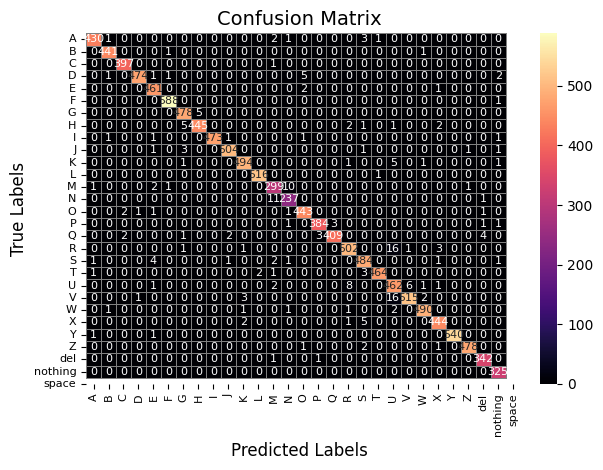

In [52]:
cm=confusion_matrix(y_test, y_pred)
labels=le.classes_
sns.heatmap(cm, annot=True, fmt='d',cmap='magma',linewidth=0.5,linecolor='gray',xticklabels=labels,yticklabels=labels,annot_kws={"size": 8})
plt.title('Confusion Matrix',fontsize=14)
plt.xlabel('Predicted Labels',fontsize=12)
plt.ylabel('True Labels',fontsize=12)
plt.xticks(rotation=90,fontsize=8)
plt.yticks(rotation=0,fontsize=8)
plt.tight_layout()
plt.show()


In [56]:
import joblib
joblib.dump(model,"asl_rf_model.pkl")
from google.colab import files
files.download("asl_rf_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
model=joblib.load("asl_rf_model.pkl")

In [58]:
!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.6 MB/s eta 0:00:00


In [85]:
import joblib
# Save it if not already saved
joblib.dump(model, "asl_rf_model.pkl")


['asl_rf_model.pkl']

In [97]:
from google.colab import files
files.upload()

Saving asl_rf_model.pkl to asl_rf_model (1).pkl


In [100]:
%%writefile app.py
import streamlit as st
import cv2
import mediapipe as mp
import numpy as np
import joblib

st.title("ASL Hand Sign Recognition")

# Load model
model = joblib.load("asl_rf_model.pkl")

# MediaPipe setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils

# Label A-Z
labels = [chr(i) for i in range(65, 91)]

uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, 1)

    if image is None:
        st.error("Failed to read the image. Please upload a valid image file.")
    else:
        image = cv2.flip(image, 1)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        result = hands.process(rgb_image)

        prediction_made = False
        predicted_label = "No hand detected"

        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])

                # Model prediction
                prediction = model.predict([landmarks])[0]
                predicted_label = labels[prediction]
                prediction_made = True

                # Draw landmarks
                mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                cv2.putText(image, f'{predicted_label}', (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

        st.image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), channels="RGB")

        if prediction_made:
            st.success(f"✅ Prediction: {predicted_label}")
        else:
            st.warning("⚠ No hand detected. Try uploading a clearer or better-lit image.")

Overwriting app.py


In [101]:
from pyngrok import ngrok
import os
import time

# Kill any previous ngrok tunnels
ngrok.kill()

# Set your Ngrok authtoken (required only once per environment/session)
# Replace YOUR_NGROK_AUTHTOKEN with your actual authtoken
os.system("2zPBQDhZj9cocgj5p8TrWZToNWr_59AEtpizhVeCur4Kef9xR")

# Start the Streamlit app in the background
!nohup streamlit run app.py --server.port 8501 > /dev/null 2>&1 &

# Wait a bit to ensure Streamlit starts
time.sleep(5)

# Create a tunnel to the Streamlit app
public_url = ngrok.connect(8501)
print(f"🚀 Your Streamlit app is live at: {public_url}")


🚀 Your Streamlit app is live at: NgrokTunnel: "https://4172-104-154-253-145.ngrok-free.app" -> "http://localhost:8501"
